In [18]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[1] "pronosticos-miad"

##### 1.  Importación de librerías requeridas

In [19]:
library(Rssa)
library(TTR)
library(quantmod)
library(xts)
library(tseries)
#library(TSA)
library(ggplot2)
library(PerformanceAnalytics) ##vamos a ver, rendimientos
library(Metrics)
library(tseries)
options(warn = -1) 

##### 2.  Descarga de datos financieros

In [20]:
start<-format(as.Date("2016-05-01"),"%Y-%m-%d")
end<-format(as.Date("2018-01-28"),"%Y-%m-%d")

precios <-function(simbolo)
{
  ##Obtener precios stocks de Yahoo FInance
  datos <- getSymbols(simbolo, auto.assign = FALSE, from=start, to=end)
  ## Elimar faltantes:
  datos<-na.omit(datos)
  ##mantener columnas con precios cierre 4:
  datos <- datos[,4]
  ##Para hacerlo datos accesibles en el global environment:
  assign(simbolo, datos, envir = .GlobalEnv)
}

##Llamar el activo de interés, pueden ser varios:
precios("META")

##### 3. Visualización de serie de interés

An xts object on 2016-05-02 / 2018-01-26 containing: 
  Data:    double [439, 1]
  Columns: META.Close
  Index:   Date [439] (TZ: "UTC")
  xts Attributes:
    $ src    : chr "yahoo"
    $ updated: POSIXct[1:1], format: "2023-05-13 06:14:18"


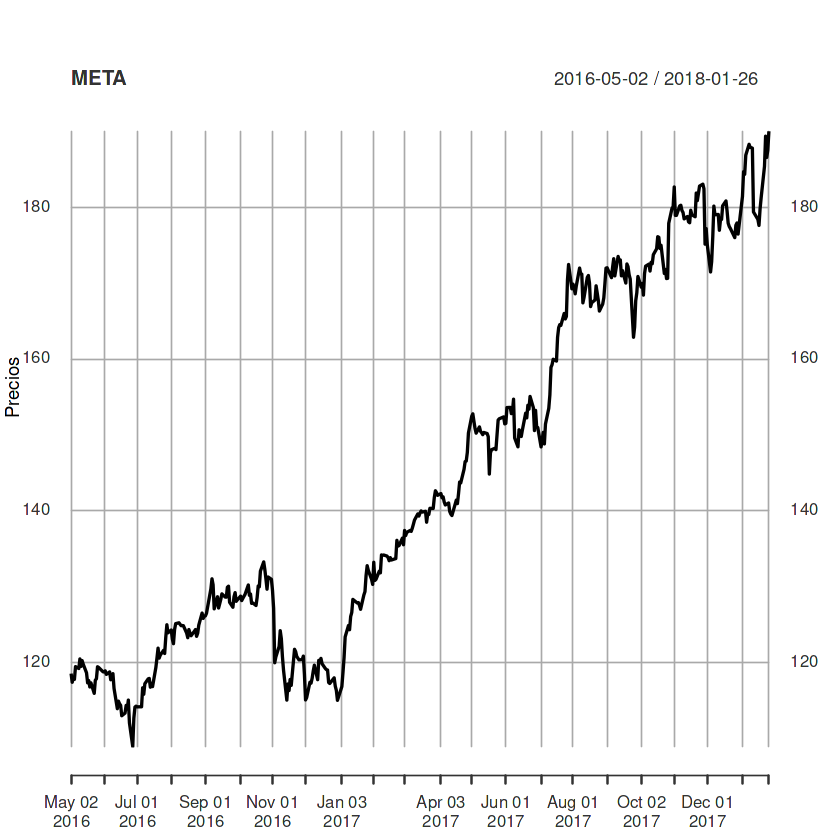

In [21]:
### Graficamos la serie
plot(META, ylab="Precios")
str(META)

##### 4. Generación de formato Indexado a fechas

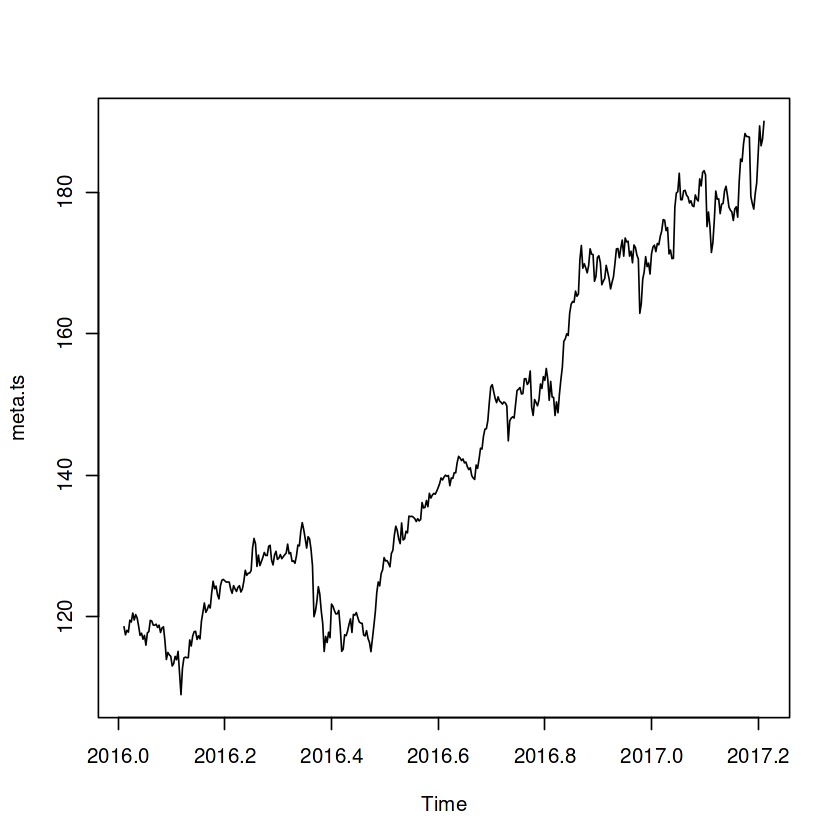

In [22]:
# Un paso importante que hay que hacer, es pasar los datos de formato xts a ts, que es el formato que emplea SSA. para ello, pasamos primero a data frame
# y luego a ts.
META <- data.frame(date=index(META), coredata(META))
META1<-META$META
##pasamos a ts
meta.ts<-ts(META1, start=c(2016,05), frequency = 365)
plot(meta.ts)

##### 5. Partición de datos de entrenamiento y prueba

In [23]:
#Partimos serie para train & test
h <- round(length(meta.ts)*0.05, digits = 0)
h

[1] 22

In [24]:
#Una vez creada la ventana h, generamos los conjuntos de entrenamiento y prueba.
train<-meta.ts[1:(length(meta.ts)-h)]
test<-meta.ts[(length(meta.ts)-h+1):length(meta.ts)]
tail(train)
head(test)
str(test)

train.ts=ts(train,start=c(2016,05), frequency = 365)

[1] 180.18 180.82 179.51 177.89 177.45 177.20

[1] 175.99 177.62 177.92 176.46 181.42 184.67

 num [1:22] 176 178 178 176 181 ...


##### 6. Pasos 1 y 2

In [25]:
##SSA embeding y separación:
s1<-ssa(train.ts)  #Hay otros métodos como el "topelitz", para series estacionarias. En este caso no aplica.
s1


Call:
ssa(x = train.ts)

Series length: 417,	Window length: 209,	SVD method: eigen
Special triples:  0

Computed:
Eigenvalues: 50,	Eigenvectors: 50,	Factor vectors: 0

Precached: 0 elementary series (0 MiB)

Overall memory consumption (estimate): 0.0864 MiB

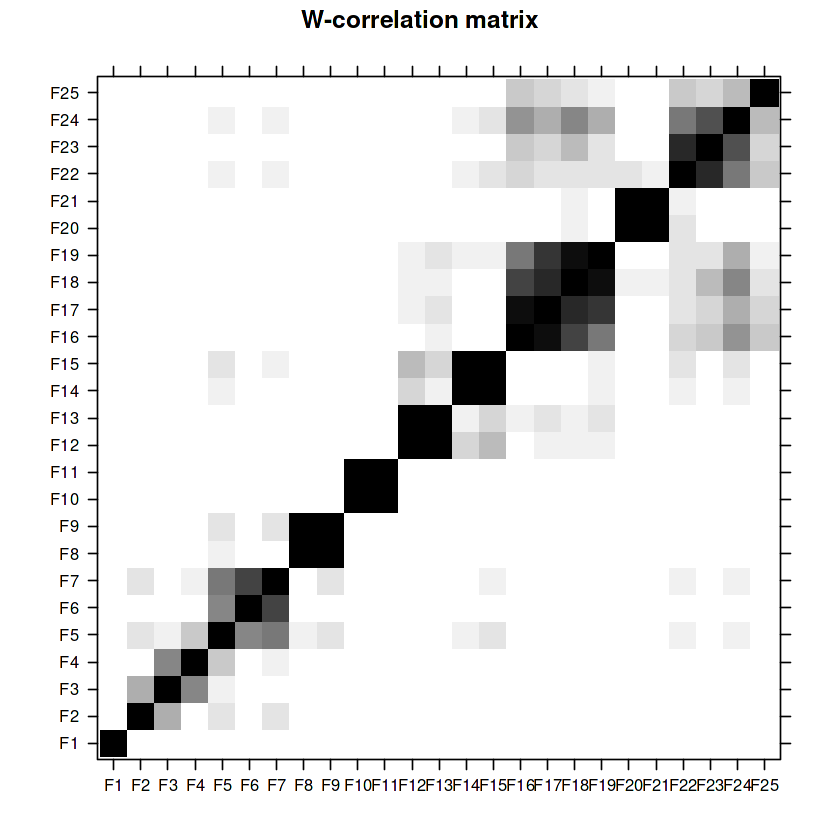

In [26]:
##Reconstrucción: empleamos las herramientas visuales para la selección.
wplot<-wcor(s1, group=1:25)
plot(wplot)

In [27]:
##Hankelización:
UniHankel=function(Y,L){
  k<-length(Y)-L+1
  outer((1:L), (1:k), function(x,y) Y[(x+y-1)])
}

In [28]:
##Función SVD
SVD<- function(Y,L){
  X<-UniHankel(Y,L)
  svd(X)
}

In [29]:
##Singular Values graph
Sing.plt<-function(Y,L){
  lambda<-log(SVD(Y,L)$d)
  d<-length(lambda)
  win<-1:d
  plot.new()
  plot.window(xlim=range(win), ylim=range(lambda))
  usr=par("usr")
  rect(usr[1], usr[3], usr[2], usr[4])
  lines(win, lambda, lwd=2)
  points(win, lambda, pch=21, bg="gray")
  axis(1)
  axis(2)
  box()
  title(xlab="Number")
  title(ylab="Log.Singular Values")}

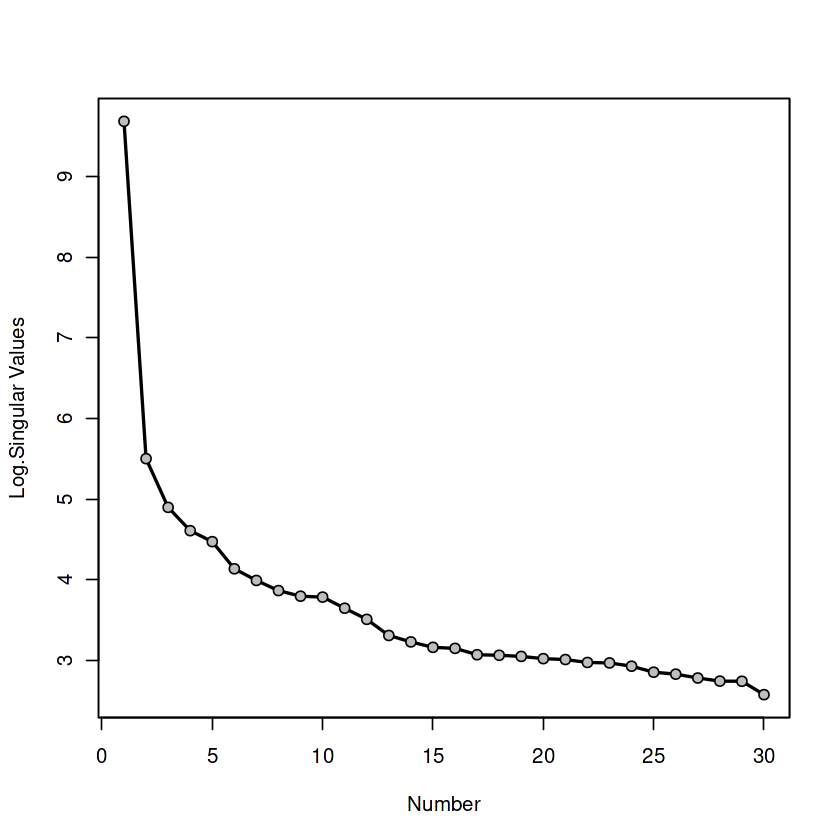

In [30]:
#Tambien generamos la scree-plot.
Sing.plt(meta.ts, 30)

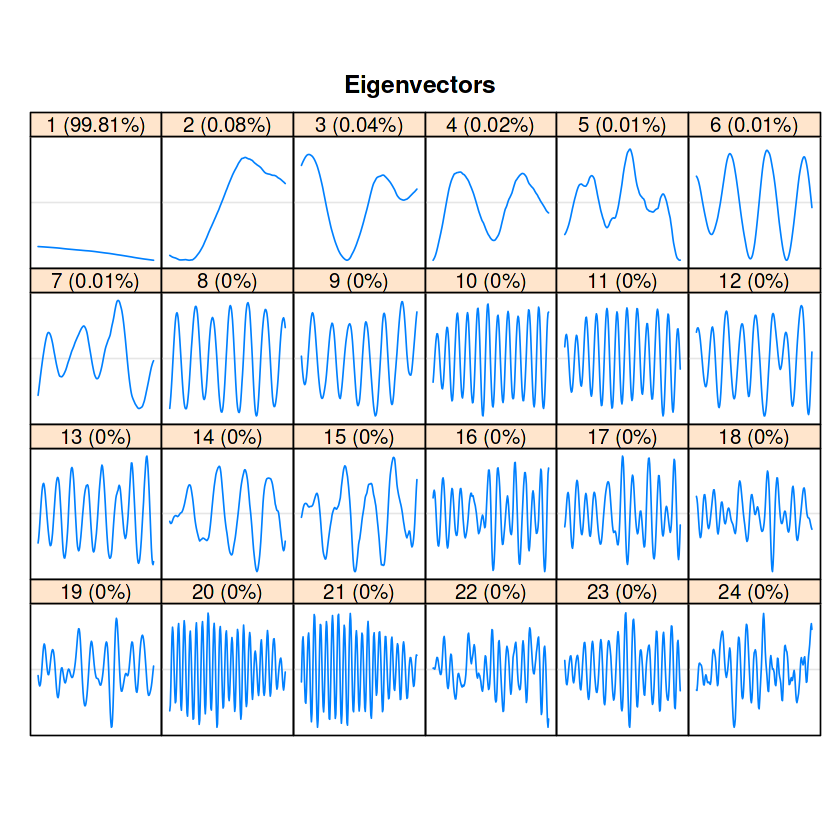

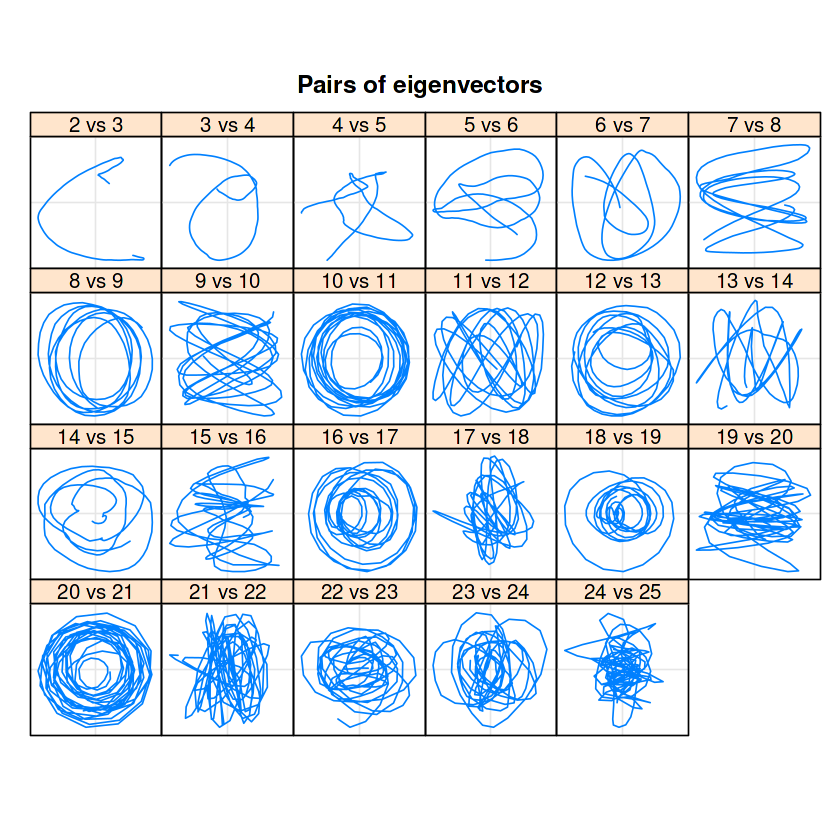

In [31]:
###Gráficas componentes 1D (compoente por componente) y la 2D (pares formen poligonos regulares : estables)
plot(s1, type="vectors", idx=1:24)
plot(s1, type= "paired", idx=2:24, plot.contrib = FALSE)

A partir de los resultados anteriores, podemos proponer que los vectores 1, 2 y 3 son candidatos para los vectores que comprenden la tendencia; mientras que los pares de vectores 8-9, 10-11, 12-13, 16-17 y 20-21 representan la estacionalidad.

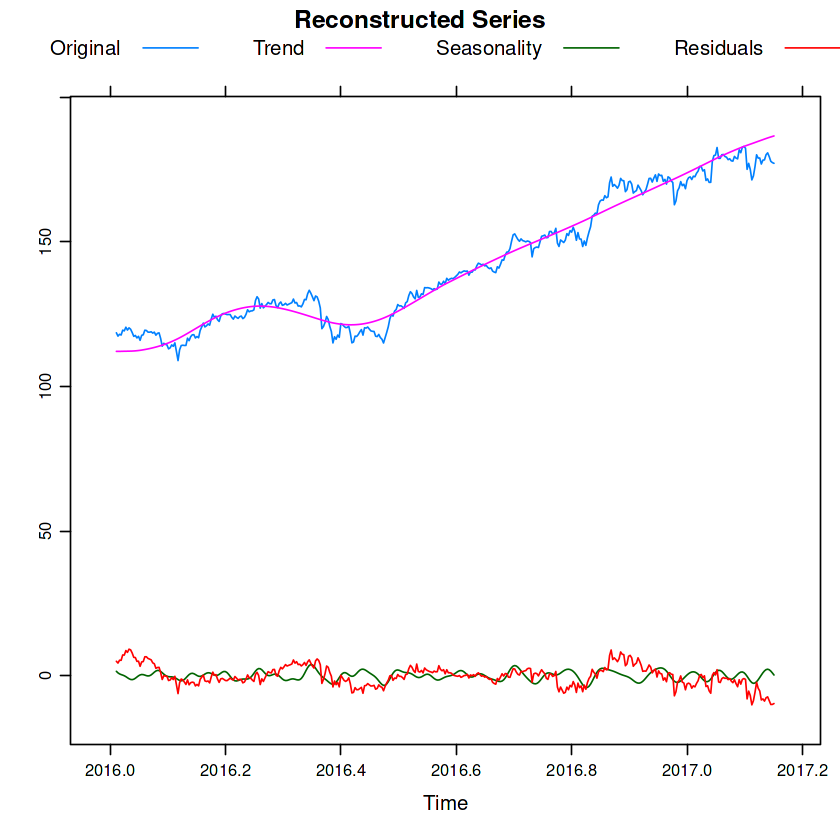

In [37]:
##Fase recontrucción:
r=reconstruct(s1, groups = list(Trend=1:3, Seasonality=c(8:9,10:11,12:13,16:17,20:21)))
plot(r, add.residuals=TRUE, add.original=TRUE, plot.method="xyplot",
     superpose=TRUE, auto.key=list(columns=4))

In [38]:
#Generamos el pronóstico señalando los tripletes de la reconstrucción.
pronostico1<-forecast(s1, groups = list(c(1:3,8:9,10:11,12:13,16:17,20:21)), len=h, method="recurrent", 
                                   interval = "prediction", level=c(0.8, 0.99),only.new=TRUE )

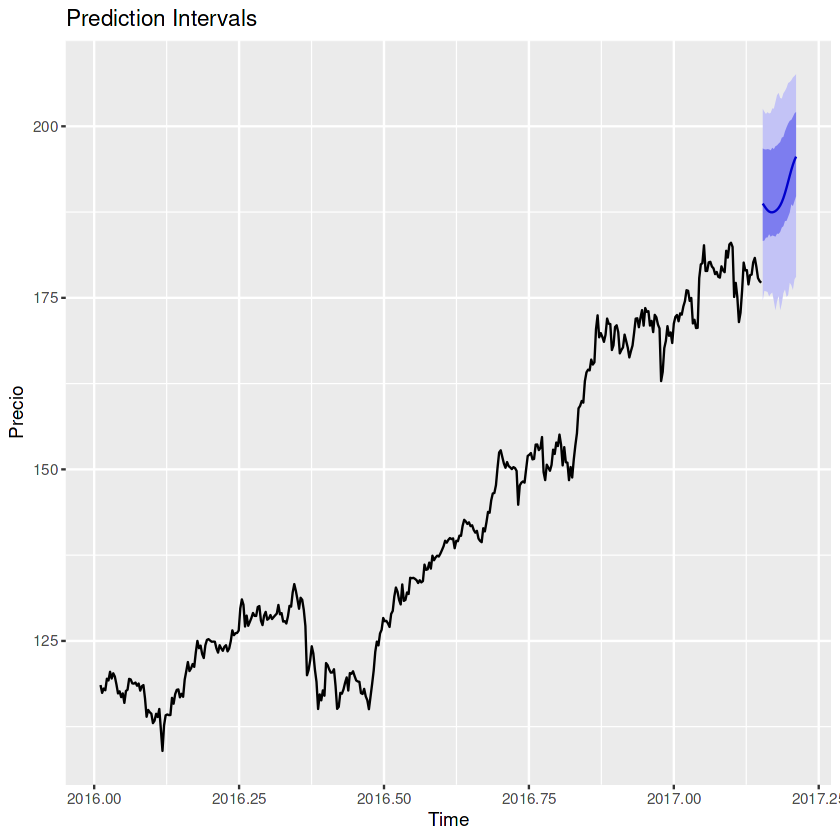

In [39]:
# Graficamos el pronóstico.
autoplot(pronostico1, type="l", main="Prediction Intervals", ylab="Precio")

In [40]:
pred<-pronostico1$mean
pred

A Time Series:
 [1] 188.7407 188.3884 188.0517 187.7736 187.5785 187.4756 187.4606 187.5224
 [9] 187.6509 187.8443 188.1119 188.4729 188.9464 189.5422 190.2553 191.0623
[17] 191.9272 192.8051 193.6470 194.4114 195.0650 195.5853

In [41]:
###Cálculo error MAPE, RMSE
library(Metrics)
Modelo <- c("SSA")

RMSE<-rmse(test,pred)
MAPE<-mape(test, pred)

resul<-data.frame(Modelo,RMSE,MAPE)

print(resul)

  Modelo     RMSE      MAPE
1    SSA 7.996308 0.0370818
